# 9. Fit Diagnostics: Pulls, Impacts, and Yields

**Pedagogical context.** This notebook covers the practical diagnostic
tools that every LHC analysis uses after fitting. The material
corresponds to the practical tutorial sessions in Cowan's RHUL and
Benasque courses and to the CMS FitDiagnostics documentation. There is
no single lecture that covers this because diagnostics are treated as
craft knowledge: something learned by doing rather than by theorem.

Three diagnostic tools are standard. Pre-fit and post-fit yield
comparisons confirm that the fit successfully adjusts the model to match
the data. Nuisance parameter pulls reveal which systematics the fit is
using (and whether any are being over-constrained). Impacts quantify how
much each nuisance parameter affects the parameter of interest, ranking
them by importance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Histogram, Sample, Channel, Model
from histimator.likelihood import fit
from histimator.diagnostics import (
    prefit_postfit_yields,
    nuisance_parameter_pulls,
    impacts,
)

## 9.1 Building a model with several systematics

To make the diagnostics meaningful, we build a model with several
nuisance parameters: a background normalisation, a shape systematic,
a luminosity uncertainty, and MC statistical uncertainties. We inject
signal and deliberately offset one nuisance parameter from nominal
to give the fit something to pull.

In [2]:
edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

sig = Sample("signal", Histogram([3, 10, 15, 10, 3], edges))
sig.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))
sig.add_lumisys("lumi", uncertainty=0.02)

bkg_nom = Histogram([50, 60, 55, 45, 40], edges)
bkg_down = Histogram([47, 55, 53, 48, 43], edges)
bkg_up   = Histogram([53, 65, 57, 42, 37], edges)

bkg = Sample("background", bkg_nom)
bkg.add_normsys("bkg_xsec", lo=0.92, hi=1.08)
bkg.add_histosys("jes", lo_hist=bkg_down, hi_hist=bkg_up)
bkg.add_staterror("mc_stat", [0.05, 0.04, 0.06, 0.08, 0.10])
bkg.add_lumisys("lumi", uncertainty=0.02)

# Generate data with mu=1.2 and a shifted JES
np.random.seed(42)
true_params = {p.name: p.value for p in sig.parameters + bkg.parameters}
true_params["mu"] = 1.2
true_params["jes"] = 0.5  # shift JES away from nominal

ch = Channel("SR")
ch.add_sample(sig)
ch.add_sample(bkg)
exp = ch.expected(true_params)
data = np.random.poisson(exp.astype(int))
ch.set_data(data)

model = Model("diagnostics_demo")
model.add_channel(ch)

result = fit(model)
print(f"Fit converged: {result.valid}")
for name in model.parameter_names:
    print(f"  {name:>25s} = {result.bestfit[name]:+.4f} +/- {result.errors[name]:.4f}")

Fit converged: True
                         mu = +0.9947 +/- 0.7288
                       lumi = +1.0017 +/- 0.0281
                   bkg_xsec = +0.3335 +/- 1.2625
                        jes = +0.0000 +/- 0.2502
         gamma_mc_stat_bin0 = +0.9959 +/- 0.0673
         gamma_mc_stat_bin1 = +1.0112 +/- 0.0547
         gamma_mc_stat_bin2 = +0.9803 +/- 0.0818
         gamma_mc_stat_bin3 = +1.0053 +/- 0.1046
         gamma_mc_stat_bin4 = +1.0343 +/- 0.1213


## 9.2 Pre-fit and post-fit yields

The pre-fit prediction uses nominal parameter values; the post-fit
prediction uses the best-fit values from the fit. Comparing these to
the data reveals how the fit adjusted the model. Large differences
between pre-fit and post-fit indicate that the fit moved nuisance
parameters substantially.

/var/folders/3w/jcz46dj964526sk_kgkg8p0r0000gn/T/ipykernel_12260/4124047772.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


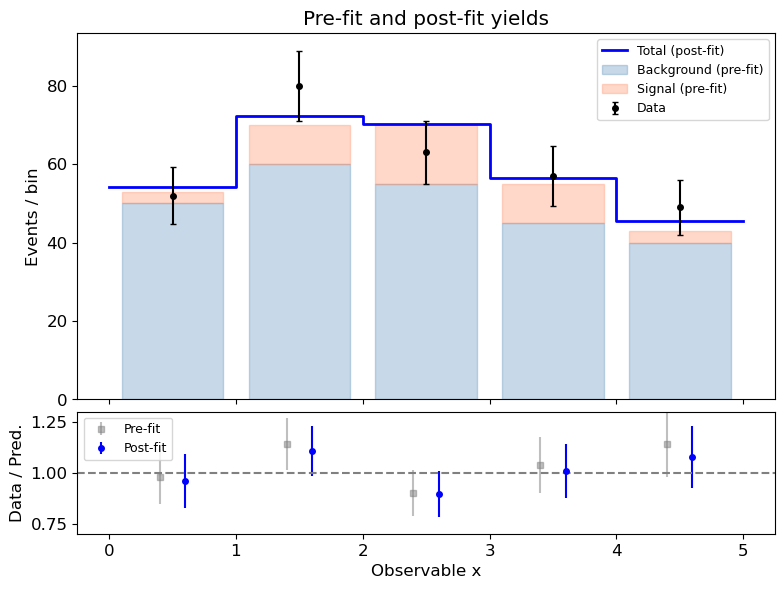

In [3]:
yields = prefit_postfit_yields(model)
ch_yields = yields["SR"]

centres = sig.histogram.centres
width = 0.8

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6.5), height_ratios=[3, 1],
                                sharex=True, gridspec_kw={"hspace": 0.05})

# Stacked pre-fit
ax1.bar(centres, ch_yields["prefit"]["samples"]["background"],
        width=width, alpha=0.3, color="steelblue", edgecolor="steelblue",
        label="Background (pre-fit)")
ax1.bar(centres, ch_yields["prefit"]["samples"]["signal"],
        width=width, alpha=0.3, color="coral", edgecolor="coral",
        bottom=ch_yields["prefit"]["samples"]["background"],
        label="Signal (pre-fit)")

# Post-fit total
ax1.step(np.append(edges[:-1], edges[-1]),
         np.append(ch_yields["postfit"]["total"], ch_yields["postfit"]["total"][-1]),
         where="post", color="blue", linewidth=2, label="Total (post-fit)")

# Data
ax1.errorbar(centres, ch_yields["data"], yerr=np.sqrt(ch_yields["data"]),
             fmt="ko", ms=4, capsize=2, label="Data")
ax1.set_ylabel("Events / bin")
ax1.legend(fontsize=9)
ax1.set_title("Pre-fit and post-fit yields")

# Ratio panel
ratio_pre = ch_yields["data"] / ch_yields["prefit"]["total"]
ratio_post = ch_yields["data"] / ch_yields["postfit"]["total"]
ax2.errorbar(centres - 0.1, ratio_pre,
             yerr=np.sqrt(ch_yields["data"]) / ch_yields["prefit"]["total"],
             fmt="s", ms=4, color="gray", alpha=0.5, label="Pre-fit")
ax2.errorbar(centres + 0.1, ratio_post,
             yerr=np.sqrt(ch_yields["data"]) / ch_yields["postfit"]["total"],
             fmt="o", ms=4, color="blue", label="Post-fit")
ax2.axhline(1, color="gray", ls="--")
ax2.set_ylabel("Data / Pred.")
ax2.set_xlabel("Observable x")
ax2.set_ylim(0.7, 1.3)
ax2.legend(fontsize=9)
plt.tight_layout()
plt.show()

## 9.3 Nuisance parameter pulls

A pull plot shows, for each nuisance parameter, how far the best-fit
value has moved from its nominal in units of the pre-fit uncertainty
(the pull), and how much the post-fit uncertainty has shrunk relative
to the pre-fit uncertainty (the constraint).

A pull near zero means the data are consistent with the nominal value
of that systematic. A pull far from zero indicates that the data prefer
a shifted value. A constraint significantly less than 1 means the data
are providing information beyond the prior, i.e. the parameter is being
over-constrained by the fit.

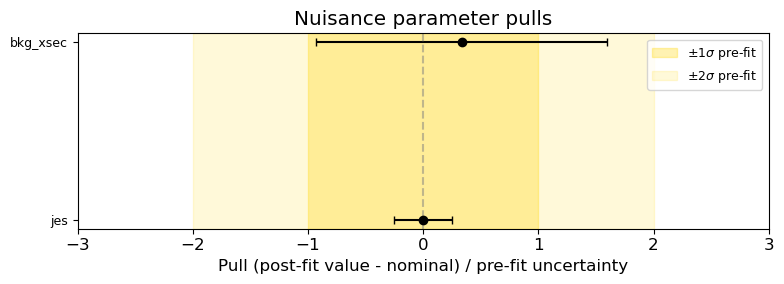

Numerical pulls:
                        jes: pull = +0.000, constraint = 0.250
                   bkg_xsec: pull = +0.334, constraint = 1.262


In [4]:
pulls = nuisance_parameter_pulls(model)

names = list(pulls.keys())
pull_vals = [pulls[n]["pull"] for n in names]
constraint_vals = [pulls[n]["constraint"] for n in names]

fig, ax = plt.subplots(figsize=(8, max(3, len(names) * 0.5)))
y_pos = np.arange(len(names))

# Pre-fit band
ax.axvspan(-1, 1, color="gold", alpha=0.3, label=r"$\pm 1\sigma$ pre-fit")
ax.axvspan(-2, 2, color="gold", alpha=0.15, label=r"$\pm 2\sigma$ pre-fit")

# Pulls with error bars showing post-fit constraint
ax.errorbar(pull_vals, y_pos, xerr=constraint_vals,
            fmt="ko", ms=6, capsize=3, linewidth=1.5)
ax.axvline(0, color="gray", ls="--", alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel("Pull (post-fit value - nominal) / pre-fit uncertainty")
ax.set_title("Nuisance parameter pulls")
ax.set_xlim(-3, 3)
ax.legend(loc="upper right", fontsize=9)
plt.tight_layout()
plt.show()

print("Numerical pulls:")
for n in names:
    print(f"  {n:>25s}: pull = {pulls[n]['pull']:+.3f}, "
          f"constraint = {pulls[n]['constraint']:.3f}")

The JES parameter shows a positive pull, as expected: we injected
the data with `jes = 0.5`, so the fit recovers a shift in that
direction. The gamma parameters for MC statistics in the last bins may
show slightly larger pulls because those bins have larger relative
uncertainties.

A constraint value below 1.0 means the post-fit uncertainty is smaller
than the pre-fit uncertainty. This happens when the data in the
measurement region provide information about that nuisance parameter
beyond what the prior constraint gives.

## 9.4 Impacts

An impact plot shows how much the parameter of interest shifts when
each nuisance parameter is fixed at its $+1\sigma$ and $-1\sigma$
post-fit values. This directly quantifies the contribution of each
systematic to the total uncertainty on the POI.

The impacts are ranked by magnitude, so the top entries are the
dominant systematics. This is the primary tool for identifying which
uncertainties to reduce in order to improve the measurement.

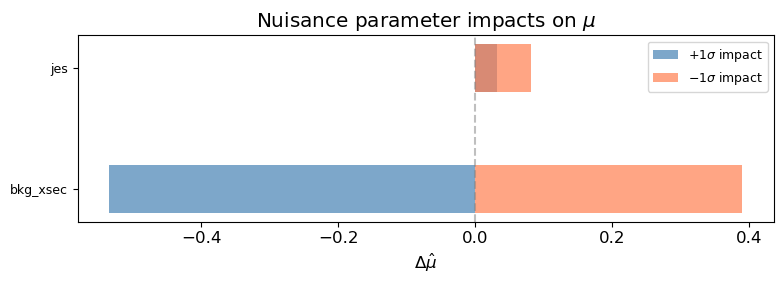

Ranked impacts:
                   bkg_xsec: up = -0.5341, down = +0.3904
                        jes: up = +0.0327, down = +0.0816


In [5]:
impact_list = impacts(model, "mu")

fig, ax = plt.subplots(figsize=(8, max(3, len(impact_list) * 0.5)))
names_imp = [e["name"] for e in impact_list]
ups = [e["impact_up"] for e in impact_list]
downs = [e["impact_down"] for e in impact_list]
y_pos = np.arange(len(names_imp))

ax.barh(y_pos, ups, height=0.4, align="center", color="steelblue",
        alpha=0.7, label=r"$+1\sigma$ impact")
ax.barh(y_pos, downs, height=0.4, align="center", color="coral",
        alpha=0.7, label=r"$-1\sigma$ impact")
ax.axvline(0, color="gray", ls="--", alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(names_imp, fontsize=9)
ax.set_xlabel(r"$\Delta\hat{\mu}$")
ax.set_title(r"Nuisance parameter impacts on $\mu$")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print("Ranked impacts:")
for e in impact_list[:5]:
    print(f"  {e['name']:>25s}: up = {e['impact_up']:+.4f}, "
          f"down = {e['impact_down']:+.4f}")

## 9.5 Interpreting diagnostics together

The three diagnostics form a coherent picture. If a nuisance parameter
shows a large pull, its impact should be examined to see whether it
significantly affects the POI. If the pre-fit and post-fit yields
disagree substantially in a particular bin, the pulls should be checked
to identify which systematic is responsible. If an impact is large, the
analysis should investigate whether the corresponding systematic can be
better constrained (by adding a control region, improving the MC
statistics, or obtaining a better auxiliary measurement).

In a well-designed analysis, no single systematic should dominate the
total uncertainty. If one does, the analysis is limited by that
systematic and the physics sensitivity can be improved by reducing it.

## Exercises

**Exercise 9.1.** Add a second channel (control region) that constrains
the `bkg_xsec` nuisance parameter. Rerun the diagnostics and compare
the pulls and impacts with and without the control region.

**Exercise 9.2.** Inject data with all nuisance parameters at nominal
(no shift). Verify that all pulls are consistent with zero and that the
pre-fit and post-fit yields agree closely.

**Exercise 9.3.** Build a model where one nuisance parameter has a very
large impact on $\mu$ (for example, by increasing its uncertainty range
from 10% to 50%). Run the impact plot and confirm it appears at the top
of the ranking.

## References

CMS Collaboration, "The CMS statistical analysis and combination tool:
COMBINE", CMS-CAT-23-001. FitDiagnostics method.

G. Cowan, *Statistical Data Analysis*, Tutorial material: Maximum
likelihood fitting, confidence regions.